# Генерируем имена с помощью RNN

Датасет содержит ~8k имен на латинице. 

Мы хотим сделать сеть, которая генерировала бы имена посимвольно.


![charseq](./charseq.jpeg)
Картинка взята из [статьи Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [0]:
# _Anna# (здесь _ = пробел, # - end of sequence)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xs=[1,2]
xs.extend("haha")
xs

[1, 2, 'h', 'a', 'h', 'a']

In [0]:
import os
start_token = " "
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]
    
print('There are {} names: '.format(len(names)))

# start your code
names = list(set(names))
# end your code
for x in names[::1000]:
    print(x)

There are 7944 names: 
 Caron#
 Evanne#
 Mireille#
 Amandi#
 Arliene#
 Joanne#
 Mamie#
 Raj#


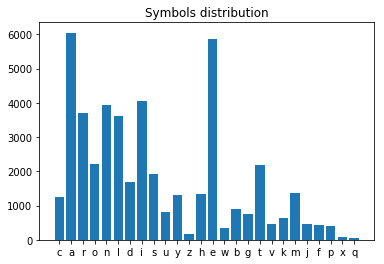

In [0]:
# TODO: постройте частоты употреблений букв

plt.figure()
plt.title('Symbols distribution')

#<your code>
from collections import defaultdict
d = defaultdict(int)
concat = ""
for i in range(len(names)):
    concat = concat+names[i]
slova = ''.join(x for x in concat if x not in "# - '").lower()
for i in slova:
    d[i] += 1 

#plt.bar(d.keys(), d.values(), width=0.4)
plt.bar(range(len(d)), d.values(), align='center')
plt.xticks(range(len(d)), list(d.keys()))
#<end code>

plt.show()

max length = 17


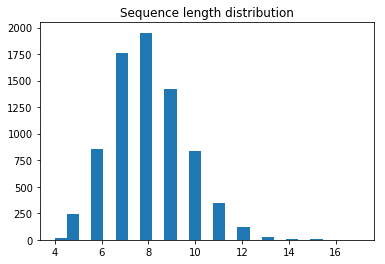

In [0]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [0]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы пробел имел номер 0

#<your code>
tokens = set() # в нашем случае это буквы, пробел, eos
#<end code>

for name in names:
    tokens.update(name)
    
tokens = list(tokens)
    
#<your code>
tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for tok, i in tok2id.items()}
#end

#!!!!где-то надо взять лист от сета, так как есть повторы в  names!!!

n_tokens = len(tokens)
print ('There are {} tokens',n_tokens)

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(sorted(tokens)))

There are {} tokens 56
Vocabular:  #'-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [0]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [0]:
# TODO: разбейте все имена на тренировочную и тестовую часть
def split_data(names, ration = 0.2):
    idx = np.arange(len(names))
    vn = int(ration * len(names))
    x = np.array(names)
    return x[idx[vn:]], x[idx[:vn]]

train_data, val_data = split_data(names)

In [0]:
print(len(train_data))
print(len(val_data))

6063
1515


In [0]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Caron#
 Mireille#
 Arliene#
 Mamie#
[[44  3 21 43  8  6 47 44 44 44]
 [44 13 49 43 16 49 28 28 16 47]
 [44 20 43 28 49 16  6 16 47 44]
 [44 13 21 11 49 16 47 44 44 44]]


In [0]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
from IPython.display import clear_output

# Char-RNN для имен (0.2 балла)

In [0]:
# обратите внимание на порядок осей при вызове forward
# http://pytorch.org/docs/master/nn.html#recurrent-layers

# TODO: заполните пропуски. Функция forward будет вызываться на каждый шаг нами

class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell="rnn", n_layers=1): # n_layers - число RNN сетей
        super(NameRNN, self).__init__()
        # добавьте возможность выбрать тип ячейки RNN/LSTM
        
        #<your code>
        self.vocab_size, self.hidden_size, self.output_size = vocab_size, hidden_size, output_size
        # if cell == LSTM:
        self.cell = cell
        self.n_layers = n_layers
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        #<end your code>

    def forward(self, input, hidden): # hidden - вход с предыдущего шаго RNN, forward - для одного шага
        #<your code>
        bs = input.size(0)
        embedded = self.embeddings(input) # input = [bs, seq_len] - > [bs, seq_len, dim]
        reordered = embedded.view(1, bs, -1)
        output, hidden = self.rnn(reordered, hidden)
        
        out = self.decoder(output)
        #<end your code>
        return out.view(bs, -1), hidden
    
    def init_hidden(self, batch_size):
        if self.cell == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

# Код для тренировки RNN (0.2 балла)

In [0]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        # можно вынести подсчет ошибки в модельку
        
        nums = to_matrix(batch)
        
        t = Variable(torch.from_numpy(nums))
        hidden = model.init_hidden(t.shape[0])
        optimizer.zero_grad()
        
        loss = 0.0
        for i in range (0, t.shape[1]-1):
            out, hidden = model.forward(t[:,i], hidden)
            loss += F.cross_entropy(out, t[:,i+1])
        
        loss.backward()
        optimizer.step()
            
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        nums = to_matrix(batch)
#         <your code>
        t = Variable(torch.from_numpy(nums))
        hidden = model.init_hidden(t.shape[0])
        
        loss = 0.0
        for i in range (0, t.shape[1]-1):
            out, hidden = model.forward(t[:,i], hidden)
            loss += F.cross_entropy(out, t[:,i+1])
                
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

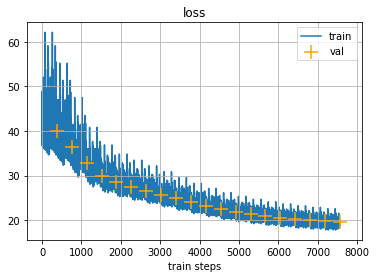

In [0]:
rnn = NameRNN(len(tokens), 16, len(tokens), cell='rnn')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

In [0]:
train_data

array([' Jordanna#', ' Gilberte#', ' August#', ..., ' Cherice#',
       ' Mohamed#', ' Ida#'],
      dtype='<U17')

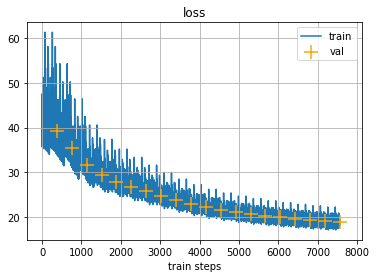

In [0]:
rnn = NameRNN(len(tokens), 16, len(tokens), cell='lstm')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

# Генерация по argmax (0.2 балла)

In [0]:
# Напишите функцию генерации продолжения строки
def gen_continuation(model, prefix=" "):
    #<your code>
    def _pick(tt):
        return tt.max(1)[1].data.numpy()[0]
    
    def _decode(tt):
        return "".join(id2tok[_] for _ in tt)
    
    hidden = model.init_hidden(1)
    nums = to_matrix(prefix)
    
    nums = Variable(torch.from_numpy(nums))
    for inp in nums:
        out, hidden = model.forward(inp, hidden)
        #picked = out.max(1)[1]
        #print(out.shape)
    #<end>
    outs = [_pick(out)]
    
    #print(outs)
    
    inp = out.max(1)[1]
    #inp = Variable(inp)
    for i in range(10):
        out, hidden = model.forward(inp, hidden)
        outs.append(_pick(out))
        inp = out.max(1)[1]
    print(prefix + _decode(outs))
    
gen_continuation(rnn, " Ma")

 Mare#        


# Генерация с семплированием (0.4 балла)

In [0]:
# Напишите функцию генерации с семплированием, температурой и несколькими вариантами
# выбор следующей буквы - СВ с распределением вероятностей, которые нам выдает модель
def gen_continuation_temp(model, prefix=" ", temperature=1.0, n=10):
    #<your code>
    def _pick(id2tok, probabilities):
        generated = np.random.choice(np.arange(len(id2tok)), p=probabilities)
        return int(generated)
    
    def _decode(tt):
        return "".join(id2tok[_] for _ in tt)
    
    hidden = model.init_hidden(1)
    nums = to_matrix(prefix)
    
    nums = Variable(torch.from_numpy(nums))
    for inp in nums:
        out, hidden = model.forward(inp, hidden)
        #picked = out.max(1)[1]
        #print(out.shape)
    #<end>
    tmp_out = out / (1.0 * temperature)
    out = F.softmax(tmp_out, dim=-1)
    out = out.data.numpy()[0]
    outs = [_pick(id2tok, out)]
    
    inp = Variable(torch.LongTensor([int(outs[-1])]))
    #inp = Variable(inp)
    for i in range(n):
        out, hidden = model.forward(inp, hidden)
        
        tmp_out = out / (1.0 * temperature)
        out = F.softmax(tmp_out, dim=-1)
        out = out.data.numpy()[0]
        
        outs.append(_pick(id2tok, out))
        inp = Variable(torch.LongTensor([int(outs[-1])]))
    print(prefix + _decode(outs))
    

gen_continuation_temp(rnn, prefix=" An", temperature=0.5, n=10)

 Aneli#       


## Дополнительное упражнение:
Посмотреть насколько далеко назад по времени распространяется градиент в RNN и LSTM сетях.

Предложите процедуру и реализуйте ее.